## Importing Libraries

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import itertools 
from sklearn.metrics import *
from sklearn.model_selection import train_test_split 
warnings.filterwarnings('ignore')
%matplotlib inline

#Importing pytorch functions and modules
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))
device = torch.device("cpu")
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

import librosa
from librosa.core import stft,istft
from  sklearn.model_selection import train_test_split
from sklearn.metrics import *
from math import log


#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Loading and preprocessing data

In [2]:
#Reading input file
x = pickle.load(open("hw4_trs.pkl","rb"))
#Creating training labels
y = np.zeros((500,1))
c=0
for i in range(0,50):
    for j in range(0,10):
        y[c]=i
        c+=1

#Reading validation file
x_val = pickle.load(open("hw4_tes.pkl","rb"))
# x_val = x_val[:,0:x.shape[1]]
#Creating validation labels
y_val = np.zeros((200,1))
c=0
for i in range(0,20):
  for j in range(0,10):
    y_val[c]=i
    c+=1

In [3]:
def stratified_subsample(arr,labels,subsamples):
    sample_size = min(subsamples/len(labels),0.99)
    arr_tr,arr_te,_,_ = train_test_split(arr,labels,test_size=sample_size,shuffle=True,stratify=labels)
    return(arr_te)

def triplet_to_data(X,x_id):
    return(torch.tensor([X[x_id[0]],X[x_id[1]],X[x_id[2]]]))

def get_stft(x):
    X_complex = stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex)
    return(X.T)

def create_pair_loader(x,labels,P_subsamples,N_subsamples):
    X = np.apply_along_axis(get_stft,1,x)
    labels = np.array(labels)
    x_ind = np.arange(0,len(labels)).reshape(-1,1)
    pair_batches = []
    batch_labels = np.zeros((P_subsamples+N_subsamples,1))
    batch_labels[0:P_subsamples]=1
    for j,spk in enumerate(np.unique(labels)):
        #print("Processing speaker:"+str(spk))
        x_spk = x_ind[np.where(labels==spk)]
        x_nspk = x_ind[np.where(labels!=spk)]
        #generating positive(same speaker) pairs
        positive_pairs = np.array(random.sample(list(itertools.combinations(x_spk,2)),P_subsamples))
        
        #generating negative(different speaker) pairs
        negative_pairs = np.array(random.sample(list(itertools.product(x_spk,x_nspk)),N_subsamples))
        
        
        all_pairs = np.concatenate((positive_pairs,negative_pairs),0)
        
        x1 = np.apply_along_axis(lambda ind:X[ind],1,all_pairs[:,0].reshape(-1,1))#.reshape((all_pairs.shape[0],X.shape[1],X.shape[2]))
        x2 = np.apply_along_axis(lambda ind:X[ind],1,all_pairs[:,1].reshape(-1,1))#.reshape((all_pairs.shape[0],X.shape[1],X.shape[2]))

        pair_batches.append((x1,x2,batch_labels))
    pair_loader = torch.utils.data.dataloader.DataLoader(pair_batches)

    return(pair_loader)

In [4]:
#Creating data loaders
train_loader = create_pair_loader(x,y,P_subsamples=45,N_subsamples=45)
val_loader = create_pair_loader(x_val,y_val,P_subsamples=45,N_subsamples=45)

## Defining model 

In [5]:
class Rnn_model(nn.Module):
    """
    Pytorch model class for removing noise from sound
    """
    def __init__(self, input_dm, n_lstm_layers, n_lstm_units, output_dm,dropout,max_len):
        
        super(Rnn_model,self).__init__()
        self.n_lstm_units = n_lstm_units
        self.output_dm = output_dm
        self.max_len = max_len
        self.dropout = dropout
        self.act1 = nn.PReLU(init=1.5)
        self.act2 = nn.PReLU(init=1.5)

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=input_dm,
            hidden_size=n_lstm_units,
            num_layers=n_lstm_layers,
            batch_first=True,
            dropout = self.dropout,
            bidirectional=True
        )
        
        # output layer which projects back to tag space
        self.fc = nn.Linear(self.n_lstm_units*2,self.output_dm)
        self.dd = nn.Dropout(self.dropout)


    def forward(self, X, X_lengths):
        
        X_packed = nn.utils.rnn.pack_padded_sequence(X,X_lengths, batch_first=True)
        X_packed, (hidden, cell) = self.lstm(X_packed)
        #X,_ = nn.utils.rnn.pad_packed_sequence(X_packed, batch_first=True,padding_value=0.0, total_length=self.max_len)
        
        hidden = hidden.reshape(hidden.shape[1],-1)
        # X = X[:,-1,:]
        
        
        X = self.act1(hidden)
        X = self.dd(X)
        
        X = self.fc(X)
        #X = self.act2(X)
        X = self.dd(X)

        # print("Mean of prediction:"+str(torch.mean(X).item()))
        # print("Median of prediction:"+str(torch.median(X).item()))
        # print("Minimum of prediction:"+str(torch.min(X).item()))

        return(X)

# class ContrastiveLoss(nn.Module):
#     """
#     Contrastive loss
#     Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
#     """

#     def __init__(self, margin):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin
#         self.eps = 1e-9

#     def forward(self, output1, output2, target, size_average=True):
#         distances = (output2 - output1).pow(2).sum(1)  # squared distances
#         losses = 0.5 * (target.float() * distances +
#                         (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
#         return losses.mean() if size_average else losses.sum()       

## Defining class for training the model

In [6]:
class train_siamese_lstm():
  def __init__(self,
               modelClass,
               train_loader,
               val_loader,
               input_dm=513,
               output_dm=128,
               dropout=0,
               max_len=40,
               n_lstm_layers=1,
               n_lstm_units=10):
    
    x1,x2,labels = next(iter(train_loader))
    self.n_train = np.sum(np.array([x1.shape[1] for x1,x2,labels in train_loader])).astype(np.float)
    self.n_val = np.sum(np.array([x1.shape[1] for x1,x2,labels in val_loader])).astype(np.float)
    print("Training data points = "+str(self.n_train))
    print("Validation data points = "+str(self.n_val))
    
    self.model = modelClass(input_dm=input_dm,
                          n_lstm_layers=n_lstm_layers,
                          n_lstm_units=n_lstm_units, 
                          output_dm=output_dm,
                          dropout=dropout,
                          max_len=max_len)
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.best_loss = torch.tensor(np.inf)

  

  def train_model(self,max_epochs,learning_rate,early_stopping_rounds,verbose=True,cutoff=0.5):
    optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    # criterion = ContrastiveLoss(margin=0.2).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2]))
    

    self.train_loss_history = []
    self.val_loss_history = []

    
    epoch = 0
    rounds = 0
    early_stopping_rounds = 5
    stop = False
    
    while ((epoch < max_epochs)&(stop==False)):
      batch_losses = []
      for x1,x2,labels in self.train_loader:
        x1 = x1.squeeze().to(device)
        x1_lengths = torch.full((x1.shape[0],1),x1.shape[1]).reshape(-1)
        x2 = x2.squeeze().to(device)
        x2_lengths = torch.full((x2.shape[0],1),x2.shape[1]).reshape(-1)
        labels = labels.squeeze().float().to(device)
        #print(torch.unique(labels,return_counts=True))
        y1 = self.model.forward(x1,x1_lengths)
        y2 = self.model.forward(x2,x2_lengths)
        y_hat_mag =  torch.bmm(y1.view(y1.shape[0], 1, y1.shape[1]), y2.view(y2.shape[0], y2.shape[1], 1)).reshape(-1,1)

        w = torch.ones(x1.shape[0])
        w[labels==0]=2
        
        loss = criterion(y_hat_mag,labels.reshape(-1,1))
        loss.backward()
        optimizer.step()
        batch_losses.append(x1.shape[0]*loss.item())
      #end of batch loop
      train_loss = np.sum(np.array(batch_losses))/self.n_train
      self.train_loss_history.append(train_loss)
      
      val_batch_losses = []
      val_eq = 0.0
      for x1,x2,labels in self.val_loader:
        x1 = x1.squeeze().to(device)
        x1_lengths = torch.full((x1.shape[0],1),x1.shape[1]).reshape(-1)
        x2 = x2.squeeze().to(device)
        x2_lengths = torch.full((x2.shape[0],1),x2.shape[1]).reshape(-1)
        labels = labels.squeeze().float().to(device)
        #print(torch.unique(labels,return_counts=True))
        y1 = self.model.forward(x1,x1_lengths)
        y2 = self.model.forward(x2,x2_lengths)
        y_hat_mag =  torch.bmm(y1.view(y1.shape[0], 1, y1.shape[1]), y2.view(y2.shape[0], y2.shape[1], 1)).reshape(-1,1)

        y_hat = F.sigmoid(y_hat_mag)

        loss = criterion(y_hat_mag,labels.reshape(-1,1))
        val_batch_losses.append(x1.shape[0]*loss.item())
        y_hat_pred = torch.gt(y_hat,cutoff).int()
        #print(torch.unique(y_hat_pred,return_counts=True))
        val_eq += torch.sum(torch.eq(y_hat_pred.reshape(-1),labels.reshape(-1))).item()
      #end of batch loop
      val_acc = float(val_eq)/self.n_val
      val_loss = np.sum(np.array(val_batch_losses))/self.n_val
      self.val_loss_history.append(val_loss)
    
      if(val_loss<self.best_loss):
        self.best_loss = val_loss
        rounds = 0
      else:
        rounds += 1


      
      if(rounds>=early_stopping_rounds):
        stop=True
        
      if(np.round(val_acc,1)>=0.7):
        stop=True
      
      
      if((verbose==True)&((epoch%5==0)|(stop==True))):
        print(stop)
        
        print("----------------------------------------------------------------------------------")
        print("EPOCH:"+str(epoch))
        if(stop==True):
            print("Training to be concluded after this epoch") 
        print("Average training loss per sample  = "+str(train_loss))
        print("Average Validation loss per sample  = "+str(val_loss))
        print("Validation accuracy = "+str(val_acc))
        
      epoch+=1
    #While loop ends

    self.plot_loss()


  def plot_loss(self):
    print("----------------------------------------------------------------------------------")
    plt.plot(self.train_loss_history)
    plt.plot(self.val_loss_history)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()     

In [7]:
ts = train_siamese_lstm(Rnn_model,
                        train_loader,
                        val_loader,
                        input_dm=513,
                        output_dm=64,
                        dropout=0.6,
                        max_len=45,
                        n_lstm_layers=1,
                        n_lstm_units=16)

Training data points = 4500.0
Validation data points = 1800.0


False
----------------------------------------------------------------------------------
EPOCH:0
Average training loss per sample  = 1.0623459017276764
Average Validation loss per sample  = 0.8707180887460708
Validation accuracy = 0.44
True
----------------------------------------------------------------------------------
EPOCH:4
Training to be concluded after this epoch
Average training loss per sample  = 0.3960317754745483
Average Validation loss per sample  = 0.3866509959101677
Validation accuracy = 0.7205555555555555
----------------------------------------------------------------------------------


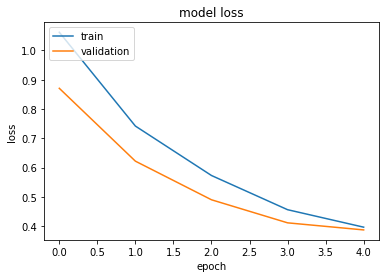

In [8]:
ts.train_model(max_epochs=100,learning_rate=0.0001,early_stopping_rounds=5,cutoff=0.5)

## Conclusion
We obtain ~= 70% accuracy on the test samples(referred to as validation accuracy in the training process)